In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode
from urllib.parse import unquote
from tqdm import tqdm 
import seaborn as sns
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot
from matplotlib.colors import Normalize

dataFolder = '../Data/wikispeedia_paths-and-graph/'
articlesDf = pd.read_csv(dataFolder+ 'articles.tsv')
articlesDf = articlesDf.iloc[10:]
articlesSeries  = pd.Series(articlesDf.index.map(lambda x : x[0])).map(lambda y : unquote(y,'utf-8'))
#articlesSeries.head(10)

linksDf = pd.read_csv(dataFolder + 'links.tsv', header=11, sep = '\t')
linksDf.columns = ['Elements','links']
linksDf['Elements'] = linksDf['Elements'].map(lambda x : unquote(x, 'utf-8'))
linksDf['links'] = linksDf['links'].map(lambda x : unquote(x, 'utf-8'))
#linksDf.reset_index()

categoriesDf = pd.read_csv(dataFolder + 'categories.tsv', header=11, sep= '\t')
categoriesDf.index = categoriesDf.index.map(lambda x : unquote(x,'utf-8'))
categoriesDf.columns = ['categories']
#categoriesDf

paths_finishedDf= pd.read_csv(dataFolder + 'paths_finished.tsv', header=15, sep= '\t')
paths_finishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'rating']
#paths_finishedDf

paths_unfinishedDf= pd.read_csv(dataFolder + 'paths_unfinished.tsv', header=16, sep= '\t')
paths_unfinishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'target', 'type']
#paths_unfinishedDf

people_skin_color = pd.read_csv(dataFolder + 'ethnic_category.tsv', header=1, sep= '\t' )
people_skin_color.columns = ['Category', 'People', 'Skin Color']
people_skin_color['People'] = people_skin_color['People'].map(lambda x : unquote(x, 'utf-8'))
people_skin_color.reset_index()
people_skin_color

,Category,People,Skin Color
0,subject.People.Historical_figures,Óengus I of the Picts,White
1,subject.People.Historical_figures,Abbas I of Persia,Arab-Persian-Bizantin
2,subject.People.Historical_figures,Adam Smith,White
3,subject.People.Historical_figures,Adriaen van der Donck,White
4,subject.People.Historical_figures,Agamemnon,White
...,...,...,...
706,subject.People.Computing_People,Jimmy Wales,White
707,subject.People.Computing_People,Linus Torvalds,White
708,subject.People.Computing_People,Richard Stallman,White
709,subject.People.Computing_People,Tim Berners-Lee,White


In [43]:
people_color =  pd.concat([people_skin_color, people_skin_color['Category'].str.split(".", expand=True)], axis=1)
people_color = people_color.drop(columns = ['Category', 0, 1])
people_color = people_color.rename(columns = {1 : 'Categories'})

unique_color=people_color['Skin Color'].unique()
rename = {
    'Blanc' : 'White',
    'Peau plus foncée' : 'Black',
    'Peau brune' : 'Black',
    'Peau plus foncée (Aborigène australien)' : 'Black',
    'Peau plus foncée (Asiatique)' : 'East Asian', 
    'Peau plus foncée (Moyen-Orient)' : 'Arab',
    'Peau plus foncée (Polynésien)' : 'Polynesian',
    'Peau plus foncée (Sherpa/Népalais)' : 'South Asian', 
    'Peau plus foncée (Ascendance africaine partielle)' : 'Black', 
    'Peau plus foncée (Indien)' : 'South Asian',
    'Peau plus foncée (Berbère)' : 'Arab',
    'Peau plus foncée (Arabe)' : 'Arab',
    'Peau plus foncée (Tibétain)' : 'East Asian',
    'Peau plus foncée (Persan)' : 'Arab',
    'Peau plus foncée (Juif)' : 'Arab', 
    'Peau plus foncée (Somalienne)' : 'Black', 
    'Peau plus foncée (Mixte)' : 'Black',
    'Peau plus foncée (Hispanique)' : 'Hispanic', 
    'Peau plus foncée (Indonésien)' : 'East Asian', 
    'Peau plus foncée (Japonais)' : 'East Asian',
    'Peau plus foncée (Vietnamien)' : 'East Asian', 
    'Peau plus foncée (Indienne)' : 'South Asian', 
    'Peau brune (Indien)' : 'South Asian',
    'Peau plus foncée (Palestinien)' : 'Arab',
    'Peau brune (Pakistano-Indien)' : 'South Asian', 
    "Blanc (D'origine libanaise)": 'White', 
    'Peau plus foncée (Brésilien)' : 'Hispanic'
}
people_color['Skin Color'] = people_color['Skin Color'].replace(rename)
people_color_dist=people_color['Skin Color'].value_counts()
print(people_color.head(50))


                                        People             Skin Color  \
0                        Óengus I of the Picts                  White   
1                            Abbas I of Persia  Arab-Persian-Bizantin   
2                                   Adam Smith                  White   
3                        Adriaen van der Donck                  White   
4                                    Agamemnon                  White   
5                                        Akbar                  Asian   
6                                    Akhenaten  Arab-Persian-Bizantin   
7                                   Alcibiades                  White   
8                           Aleksey Arakcheyev                  White   
9                           Alexander Hamilton                  White   
10                                Amda Seyon I                  Black   
11  Armand Jean du Plessis, Cardinal Richelieu                  White   
12                                   Attalus I     

In [44]:
# création d'un dataframe dont le but sera de garder seulement les pages wikipedia de personnes et les liens vers d'autres personnes:
people_links= linksDf

# On enlève tous les accents et espaces des dataframe people_color (contenant toutes les personnes et leur ethnie) et people_links
# (contenant toutes les pages wikipedia et leurs liens) pour pouvoir les comparer:
people_color.People= people_color.People.str.replace(' ', '_')
people_color.People= people_color.People.apply(unidecode)
people_links.Elements= people_links.Elements.apply(unidecode)

# On supprime toutes les pages wikipedia qui ne sont pas des personnes (colonne 'Elements'): 
indices_to_delete=[]
for i in range (0,len(people_links)): 
    if people_links['Elements'][i] not in people_color.People.values: 
        indices_to_delete=indices_to_delete + [i]
people_links= people_links.drop(indices_to_delete)
people_links=people_links.reset_index(drop=True)


In [45]:
print(people_links)
# jonah lomu, le seul polynésien, est enlevé du dataframe car aucun lien sur sa page wikipedia n'emmène vers d'autres personnes

            Elements            links
0      Edouard_Manet         Absinthe
1      Edouard_Manet             Beer
2      Edouard_Manet     Claude_Monet
3      Edouard_Manet  Diego_Velázquez
4      Edouard_Manet  Edgar_Allan_Poe
...              ...              ...
16389      Zoroaster             Star
16390      Zoroaster       Tajikistan
16391      Zoroaster     Turkmenistan
16392      Zoroaster         Voltaire
16393      Zoroaster             Zeus

[16394 rows x 2 columns]


In [46]:
# On supprime tous les liens qui ne sont pas des personnes (colonne 'links'): 
indices_to_delete=[]
for i in range (0,len(people_links)): 
    if people_links['links'][i] not in people_color.People.values: 
        indices_to_delete=indices_to_delete + [i]
people_links= people_links.drop(indices_to_delete)
people_links=people_links.reset_index(drop=True)
print(people_links)
print(people_color)

           Elements                links
0     Edouard_Manet         Claude_Monet
1     Edouard_Manet      Edgar_Allan_Poe
2     Edouard_Manet       Francisco_Goya
3     Edouard_Manet              Raphael
4       Abel_Tasman           James_Cook
...             ...                  ...
2998      Zoroaster  Friedrich_Nietzsche
2999      Zoroaster                Jesus
3000      Zoroaster             Muhammad
3001      Zoroaster                Plato
3002      Zoroaster             Voltaire

[3003 rows x 2 columns]
                    People             Skin Color                   2
0    Oengus_I_of_the_Picts                  White  Historical_figures
1        Abbas_I_of_Persia  Arab-Persian-Bizantin  Historical_figures
2               Adam_Smith                  White  Historical_figures
3    Adriaen_van_der_Donck                  White  Historical_figures
4                Agamemnon                  White  Historical_figures
..                     ...                    ...              

In [47]:
# On veut connaitre l'ethnie de toutes les personnes des pages wikipedia ('E_color') et celle des personnes en lien ('l_color'):
E_color = []
l_color = []
for i in range (0, len(people_links)):
    for j in range (0, len(people_color)):
        if people_links['Elements'][i]== people_color['People'][j]:
            # prend la couleur de la personne
            E_color= E_color+ [people_color['Skin Color'][j]]
            break      
    for k in range (0, len(people_color)):
        if people_links['links'][i]== people_color['People'][k]:
            # prend la couleur de la personne
            l_color= l_color+ [people_color['Skin Color'][k]]
            break 

In [48]:
people_links['E_color']= E_color
people_links['l_color']= l_color
print(people_links.head(50))
print(len(people_links))
# On obtient quelques NaN qu'il va falloir ajuster, sinon c'est cramer qu'on a fait ca avec l'IA 

             Elements                     links                E_color  \
0       Edouard_Manet              Claude_Monet                  White   
1       Edouard_Manet           Edgar_Allan_Poe                  White   
2       Edouard_Manet            Francisco_Goya                  White   
3       Edouard_Manet                   Raphael                  White   
4         Abel_Tasman                James_Cook                  White   
5   Abraham_Goldfaden              George_Eliot                  White   
6   Abraham_Goldfaden       William_Shakespeare                  White   
7     Abraham_Lincoln            Andrew_Johnson                  White   
8     Abraham_Lincoln            Charles_Darwin                  White   
9     Abraham_Lincoln            Charles_Sumner                  White   
10    Abraham_Lincoln        Frederick_Douglass                  White   
11    Abraham_Lincoln            James_Buchanan                  White   
12    Abraham_Lincoln             Jame

In [49]:
# À présent, on veut connaitre le nombre de pages wikipedia de personnes d'une certaine ethnie qui emmène vers une autre ethnie 
# par exemple le nombre de pages wikipedia d'une personne noire qui emmenne vers une personne arabe = 7 
ethni_pair = people_links.groupby(['E_color', 'l_color']).size().reset_index(name='nb_links')
print(ethni_pair)

                  E_color                l_color  nb_links
0         American Indian               Hispanic         1
1   Arab-Persian-Bizantin  Arab-Persian-Bizantin        15
2   Arab-Persian-Bizantin                  Asian         8
3   Arab-Persian-Bizantin                  Black         1
4   Arab-Persian-Bizantin                  White        41
5                   Asian  Arab-Persian-Bizantin         6
6                   Asian                  Asian        38
7                   Asian                  Black         5
8                   Asian                  White        50
9   Australian Aboriginal                  White         1
10                  Black  Arab-Persian-Bizantin         5
11                  Black                  Asian         2
12                  Black                  Black        24
13                  Black               Hispanic         3
14                  Black                  White        49
15               Hispanic  Arab-Persian-Bizantin        

In [50]:
print(ethni_pair.nb_links.sum())
# On voit que 49 pages n'ont pas de liens vers d'autres personnes, et que les autres personnes n'ont pas de liens menant vers cette page 

2954


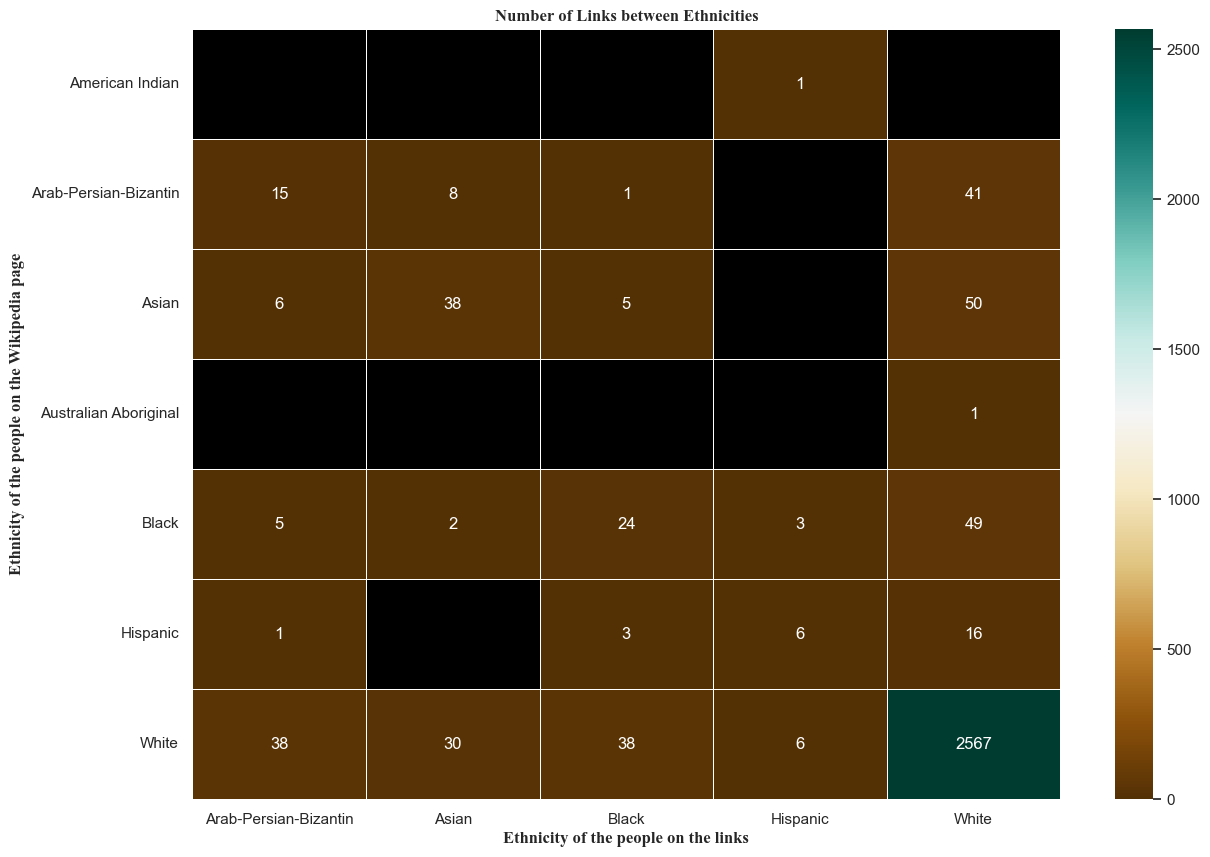

In [60]:
# Assume ethni_pair, values, index, and columns are defined

# Pivot table
heatmap_matrix = ethni_pair.pivot_table(values='nb_links', index='E_color', columns='l_color', fill_value=0)

# Set a white grid style using seaborn
sns.set(style="whitegrid")

# Define a colormap with black for zero values
cmap = sns.color_palette("BrBG", as_cmap=True)
cmap.set_bad(color='black')

norm = Normalize(vmin=heatmap_matrix.values.min(), vmax=heatmap_matrix.values.max())

# Create a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_matrix, annot=True, cmap=cmap, fmt=".0f", linewidths=.5, mask=(heatmap_matrix == 0),norm=norm)

# Set plot title and labels
plt.title('Number of Links between Ethnicities', fontname="Times New Roman", fontweight="bold")
plt.xlabel('Ethnicity of the people on the links',fontname="Times New Roman", fontweight="bold")
plt.ylabel('Ethnicity of the people on the Wikipedia page',fontname="Times New Roman", fontweight="bold")

# Show the plot
plt.show()



In [53]:
# Pour avoir quelque chose de moins biaisé, on va chercher a connaitre la proportion de lien entre chaque ethnie. Pour cela on divise 
# chaque pair de liens par le nombre total de liens que possède les pages wikipedia de personnes d'une certaine ethnie.  
# Ce qui nous donne: 

links_per_ethni= ethni_pair.groupby(['E_color']).sum().reset_index()
print(links_per_ethni)
ethni_pair['nb_links_reajust']= ethni_pair.nb_links
for i in range (0, len(links_per_ethni)):
    for j in range (0, len(ethni_pair)):
        if ethni_pair['E_color'][j]== links_per_ethni['E_color'][i]: 
            ethni_pair['nb_links_reajust'][j]= ethni_pair['nb_links'][j]/links_per_ethni['nb_links'][i]

print(ethni_pair)
# nickel, maintenant comment on fait pour prendre en compte le fait qu'on a beaucoup plus de chance d'arriver 
# sur la page d'un blanc aussi, simplement parce qu'il y a plus de blanc dans le jeu? --> normaliser l_color en gros

                 E_color                                       l_color  \
0        American Indian                                      Hispanic   
1  Arab-Persian-Bizantin          Arab-Persian-BizantinAsianBlackWhite   
2                  Asian          Arab-Persian-BizantinAsianBlackWhite   
3  Australian Aboriginal                                         White   
4                  Black  Arab-Persian-BizantinAsianBlackHispanicWhite   
5               Hispanic       Arab-Persian-BizantinBlackHispanicWhite   
6                  White  Arab-Persian-BizantinAsianBlackHispanicWhite   

   nb_links  
0         1  
1        65  
2        99  
3         1  
4        83  
5        26  
6      2679  
                  E_color                l_color  nb_links  nb_links_reajust
0         American Indian               Hispanic         1          1.000000
1   Arab-Persian-Bizantin  Arab-Persian-Bizantin        15          0.230769
2   Arab-Persian-Bizantin                  Asian         8      

/var/folders/qv/jxqksgr511n2kd5_v801s5vc0000gn/T/ipykernel_93367/2024854410.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethni_pair['nb_links_reajust'][j]= ethni_pair['nb_links'][j]/links_per_ethni['nb_links'][i]
/var/folders/qv/jxqksgr511n2kd5_v801s5vc0000gn/T/ipykernel_93367/2024854410.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethni_pair['nb_links_reajust'][j]= ethni_pair['nb_links'][j]/links_per_ethni['nb_links'][i]
/var/folders/qv/jxqksgr511n2kd5_v801s5vc0000gn/T/ipykernel_93367/2024854410.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error o

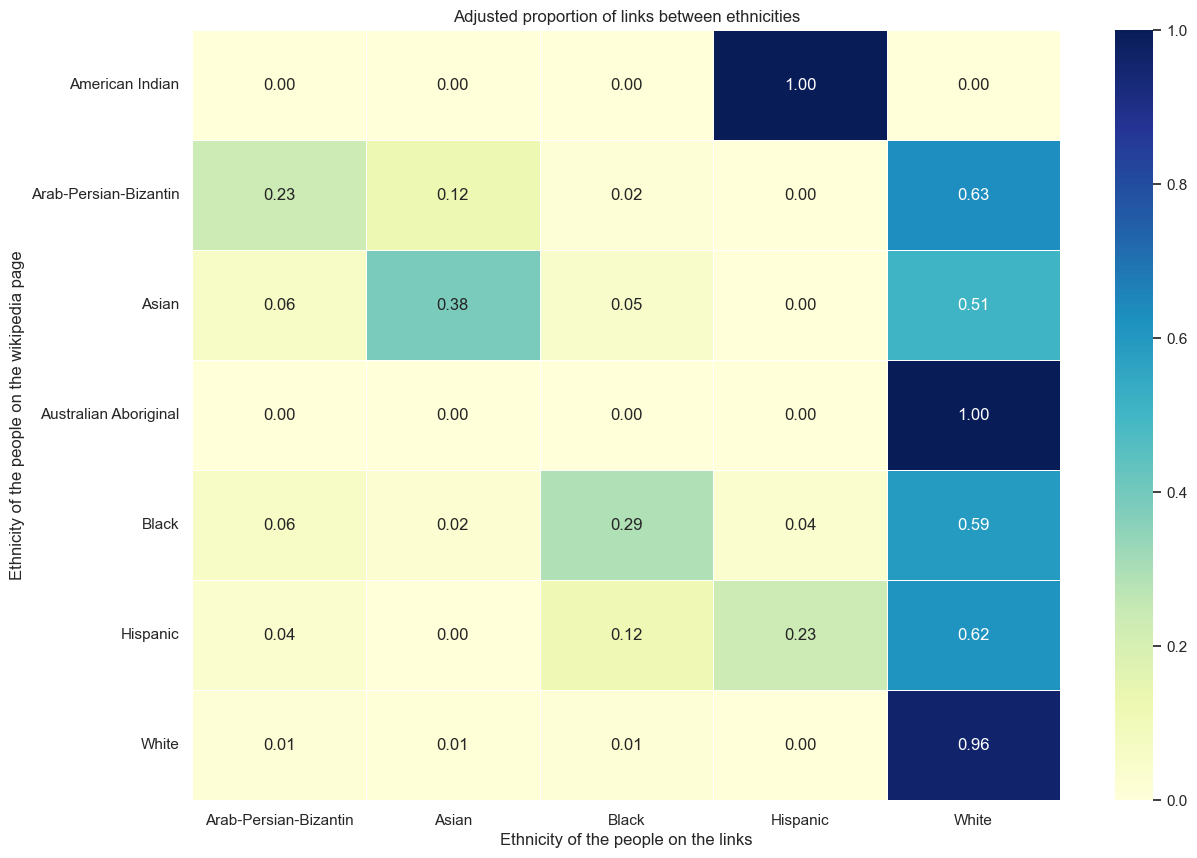

In [54]:
# Pivot the DataFrame for heatmap
heatmap_matrix = ethni_pair.pivot_table(values='nb_links_reajust', index='E_color', columns='l_color', fill_value=0)

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_matrix, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)

# Set plot title and labels
plt.title('Adjusted proportion of links between ethnicities')
plt.xlabel('Ethnicity of the people on the links')
plt.ylabel('Ethnicity of the people on the wikipedia page')

# Show the plot
plt.show()